In [1]:
import pandas as pd
from math import cos, radians, sqrt
from sklearn.neighbors import BallTree
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import warnings
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.formula.api as smf
from scipy.stats import skew
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from matplotlib.ticker import PercentFormatter

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)
np.set_printoptions(suppress = True)
np.set_printoptions(precision = 2)

In [3]:
raw = "C:\\Users\\taavi\\Desktop\\BPHIL\\Raw data\\"
clean = "C:\\Users\\taavi\\Desktop\\BPHIL\\Clean data\\"

In [4]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
parcels = parcels.loc[parcels['year'] >= 2020]
demos = pd.read_csv(clean + 'blight_and_demos.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)
demos['blight_sqrt'] = demos['blight_sqrt'].astype(str)

In [5]:
testing = (
    parcels
    [['parcelID', 'lat', 'lng', 'year', 'blight', 'blight_sqrt', 'values_smoothed', 'pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']]
    .merge(right = demos[['parcelID', 'year', 'demos_count_decayed']], on = ['parcelID', 'year'], how = 'left')
)
testing

,parcelID,lat,lng,year,blight,blight_sqrt,values_smoothed,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,demos_count_decayed
0,0001A00100000000,40.44,-80.01,2020,1,2,"392,351.83",0.03,-0.00,0.06,0.09,0.02,0.00
1,0001A00100000000,40.44,-80.01,2021,1,2,"405,024.55",-0.04,0.02,0.05,-0.02,NaN,0.00
2,0001A00100000000,40.44,-80.01,2022,1,2,"390,515.08",0.06,0.09,0.02,NaN,NaN,0.00
3,0001A00100000000,40.44,-80.01,2023,1,2,"414,644.52",0.03,-0.04,NaN,NaN,NaN,0.00
4,0001A00100000000,40.44,-80.01,2024,1,2,"426,485.03",-0.07,NaN,NaN,NaN,NaN,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
864181,8120X00002000000,40.43,-80.07,2021,1,1,"93,186.58",0.10,0.19,0.17,0.29,NaN,0.00
864182,8120X00002000000,40.43,-80.07,2022,1,1,"102,715.80",0.08,0.06,0.17,NaN,NaN,0.40
864183,8120X00002000000,40.43,-80.07,2023,1,1,"110,727.40",-0.02,0.09,NaN,NaN,NaN,0.00
864184,8120X00002000000,40.43,-80.07,2024,1,1,"108,990.20",0.10,NaN,NaN,NaN,NaN,0.00


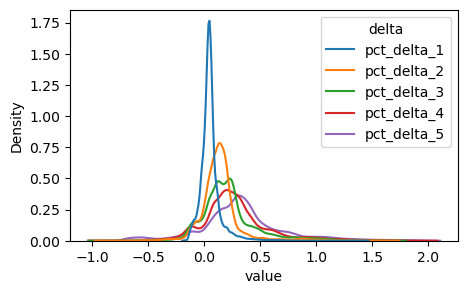

In [ ]:
toPlot = (
    testing
    .loc[np.where((testing[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']] > 2).sum(axis = 1) > 0, False, True)]
    .loc[lambda x: x['year'] == 2020]
    [['parcelID', 'pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']]
    .melt(id_vars = 'parcelID', var_name = 'delta', value_name = 'value')
)

plt.figure(figsize = (5, 3))
sns.kdeplot(toPlot, x = 'value', hue = 'delta')
plt.show()

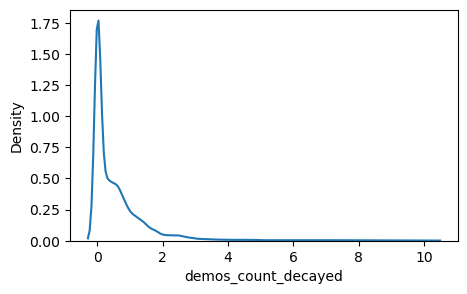

In [7]:
plt.figure(figsize = (5, 3))
sns.kdeplot(testing.loc[testing['year'] == 2020]['demos_count_decayed'])
plt.show()

In [21]:
model = smf.ols('pct_delta_1 ~ demos_count_decayed', testing.loc[testing['year'] == 2021]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            pct_delta_1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1194.
Date:                Thu, 18 Sep 2025   Prob (F-statistic):          1.72e-260
Time:                        22:32:08   Log-Likelihood:                 24159.
No. Observations:              144031   AIC:                        -4.831e+04
Df Residuals:                  144029   BIC:                        -4.829e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0872    